# Hypotesis

* Which team has the best defensive, midfield, and attacking players?
* Is there really a home team advantage?
* Do teams with more offensive players score more goals? And teams with stronger goalkeepers receive fewer goals?
* Which team has the longest winning streak?
* Does the best team always win? Can you explain why a weaker team someteams wins?

In [78]:
from datetime import date
from itertools import groupby

from category_encoders.target_encoder import TargetEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from plotnine import ggplot, geom_bar, facet_wrap, aes, geom_point, coord_flip
from plotnine.coords import coord_cartesian
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import ztest as ztest
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay, precision_recall_curve, classification_report
from sklearn.model_selection import cross_val_score, train_test_split

# EDA

In [2]:
data = pd.read_csv("international_matches.csv", parse_dates=["date"])

In [3]:
data.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,1993-08-08,Bolivia,Uruguay,South America,South America,59,22,0,0,3,...,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993-08-08,Brazil,Mexico,South America,North America,8,14,0,0,1,...,No,Draw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1993-08-08,Ecuador,Venezuela,South America,South America,35,94,0,0,5,...,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1993-08-08,Guinea,Sierra Leone,Africa,Africa,65,86,0,0,1,...,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1993-08-08,Paraguay,Argentina,South America,South America,67,5,0,0,1,...,No,Lose,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23921 entries, 0 to 23920
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           23921 non-null  datetime64[ns]
 1   home_team                      23921 non-null  object        
 2   away_team                      23921 non-null  object        
 3   home_team_continent            23921 non-null  object        
 4   away_team_continent            23921 non-null  object        
 5   home_team_fifa_rank            23921 non-null  int64         
 6   away_team_fifa_rank            23921 non-null  int64         
 7   home_team_total_fifa_points    23921 non-null  int64         
 8   away_team_total_fifa_points    23921 non-null  int64         
 9   home_team_score                23921 non-null  int64         
 10  away_team_score                23921 non-null  int64         
 11  tournament     

In [4]:
data.isna().sum()

date                                 0
home_team                            0
away_team                            0
home_team_continent                  0
away_team_continent                  0
home_team_fifa_rank                  0
away_team_fifa_rank                  0
home_team_total_fifa_points          0
away_team_total_fifa_points          0
home_team_score                      0
away_team_score                      0
tournament                           0
city                                 0
country                              0
neutral_location                     0
shoot_out                            0
home_team_result                     0
home_team_goalkeeper_score       15542
away_team_goalkeeper_score       15826
home_team_mean_defense_score     16134
home_team_mean_offense_score     15411
home_team_mean_midfield_score    15759
away_team_mean_defense_score     16357
away_team_mean_offense_score     15609
away_team_mean_midfield_score    15942
dtype: int64

## Test data

In [93]:
assert all(data["date"].dt.date < date.today())

assert all((data["home_team_goalkeeper_score"] >= 0) | (data["home_team_goalkeeper_score"].isna()))
assert all((data["home_team_mean_defense_score"] >= 0) | (data["home_team_mean_defense_score"].isna()))
assert all((data["home_team_mean_offense_score"] >= 0) | (data["home_team_mean_offense_score"].isna()))
assert all((data["home_team_mean_midfield_score"] >= 0) | (data["home_team_mean_midfield_score"].isna()))

assert all((data["away_team_goalkeeper_score"] >= 0) | (data["away_team_goalkeeper_score"].isna()))
assert all((data["away_team_mean_defense_score"] >= 0) | (data["away_team_mean_defense_score"].isna()))
assert all((data["away_team_mean_offense_score"] >= 0) | (data["away_team_mean_offense_score"].isna()))
assert all((data["away_team_mean_midfield_score"] >= 0) | (data["away_team_mean_midfield_score"].isna()))

assert all((data["shoot_out"] == "Yes") | (data["shoot_out"] == "No"))

assert all(data["home_team_score"] >= 0)
assert all(data["home_team_score"] >= 0)

# Identify when we have scoring data for team sections

In [5]:
names_scores = [
    "home_team_goalkeeper_score",
    "away_team_goalkeeper_score",
    "home_team_mean_defense_score",
    "home_team_mean_offense_score",
    "home_team_mean_midfield_score",
    "away_team_mean_defense_score",
    "away_team_mean_offense_score",
    "away_team_mean_midfield_score",
]

columns_has_score = ~data[names_scores].isna()

any_score = columns_has_score.any(axis=1)

In [6]:
oldest_element_has_score = data[any_score].index.min()
most_recent_element_has_score = data[any_score].index.max()

## Oldest match in which team sections were scored

In [7]:
data.iloc[[oldest_element_has_score]]

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
8262,2004-09-03,Maldives,Oman,Africa,Asia,142,50,0,0,1,...,No,Lose,NaN,70.0,NaN,NaN,NaN,NaN,NaN,NaN


## Most recent match in which team section scores were recorded

In [8]:
data.iloc[[most_recent_element_has_score]]

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
23920,2022-06-14,Korea Republic,Egypt,Asia,Africa,29,32,1519,1500,4,...,No,Win,75.0,NaN,73.0,80.0,73.8,NaN,79.3,70.8


# Which team has the best defensive, midfield and attacking players?

In [9]:
columns_home_team = [
    "date",
    "home_team",
    "home_team_fifa_rank",
    "home_team_total_fifa_points",
    "home_team_score",
    "home_team_goalkeeper_score",
    "home_team_mean_defense_score",
    "home_team_mean_offense_score",
    "home_team_mean_midfield_score",
]

columns_away_team = [
    "date",
    "away_team",
    "away_team_fifa_rank",
    "away_team_total_fifa_points",
    "away_team_score",
    "away_team_goalkeeper_score",
    "away_team_mean_defense_score",
    "away_team_mean_offense_score",
    "away_team_mean_midfield_score",
]

matches_with_score = data.iloc[
    oldest_element_has_score:most_recent_element_has_score
]

data_home_team = matches_with_score[columns_home_team]
data_away_team = matches_with_score[columns_away_team]

data_home_team_renamed = data_home_team.rename(
    mapper=lambda x: x.replace("home_team_", ""), axis=1
)
data_home_team_renamed = data_home_team_renamed.rename(
    mapper=lambda x: x.replace("home_team", "team"), axis=1
)

data_away_team_renamed = data_away_team.rename(
    mapper=lambda x: x.replace("away_team_", ""), axis=1
)
data_away_team_renamed = data_away_team_renamed.rename(
    mapper=lambda x: x.replace("away_team", "team"), axis=1
)


score_countries = pd.concat(
    [data_home_team_renamed, data_away_team_renamed], axis=0
)


In [10]:
score_countries["year"] = score_countries["date"].dt.year

## Do team scores change throughout the year?

In [11]:
columns_score = [
    "mean_defense_score",
    "mean_offense_score",
    "mean_midfield_score",
    "goalkeeper_score",
]

var_score = score_countries.groupby(["year", "team"])[
    columns_score
].var()


In [12]:
score_vary_in_year = var_score.apply(lambda x: x>0)

print(score_vary_in_year.any())

mean_defense_score     True
mean_offense_score     True
mean_midfield_score    True
goalkeeper_score       True
dtype: bool


In [13]:
var_score[score_vary_in_year.values]

mean_defense_score  mean_offense_score  mean_midfield_score  \
year team                                                                    
2005 Albania                  NaN            4.314333             0.058333   
     Albania                  NaN            4.314333             0.058333   
     Algeria               0.0000            0.402381             0.952381   
     Algeria               0.0000            0.402381             0.952381   
     Angola                0.0000            0.818182                  NaN   
...                           ...                 ...                  ...   
2021 Wales                 0.0105            2.362500             0.443625   
     Wales                 0.0105            2.362500             0.443625   
     Wales                 0.0105            2.362500             0.443625   
     Zambia                   NaN            0.504000                  NaN   
     Zimbabwe              0.0000            5.770909             0.000000   

               goalkeeper_score  
year team                        
2005 Albania                NaN  
     Albania                NaN  
     Algeria             0.0000  
     Algeria             0.0000  
     Angola              0.0000  
...                         ...  
2021 Wales               0.2625  
     Wales               0.2625  
     Wales               0.2625  
     Zambia                 NaN  
     Zimbabwe               NaN  

[4347 rows x 4 columns]

## Average scores per session

In [14]:
average_defense_country_year = score_countries.groupby(["year", "team"])[
    "mean_defense_score"
].mean()
average_defense_country_year.sort_values(ascending=False)


year  team      
2004  Italy         91.800000
2005  Italy         91.000000
2004  England       90.500000
2005  England       90.045455
2006  Italy         89.450000
                      ...    
2022  Uzbekistan          NaN
      Vanuatu             NaN
      Vietnam             NaN
      Yemen               NaN
      Zambia              NaN
Name: mean_defense_score, Length: 3550, dtype: float64

In [15]:
average_offense_country_year = score_countries.groupby(["year", "team"])[
    "mean_offense_score"
].mean()
average_offense_country_year.sort_values(ascending=False)


year  team             
2004  Netherlands          93.0
      France               93.0
2005  Brazil               92.4
2004  Italy                92.3
      Brazil               92.3
                           ... 
2022  US Virgin Islands     NaN
      Uzbekistan            NaN
      Vanuatu               NaN
      Vietnam               NaN
      Yemen                 NaN
Name: mean_offense_score, Length: 3550, dtype: float64

In [16]:
average_midfield_country_year = score_countries.groupby(["year", "team"])[
    "mean_midfield_score"
].mean()
average_midfield_country_year.sort_values(ascending=False)


year  team    
2004  France      93.200000
      England     91.200000
2005  France      90.909091
2006  Brazil      90.500000
2005  Brazil      90.350000
                    ...    
2022  Vanuatu           NaN
      Vietnam           NaN
      Yemen             NaN
      Zambia            NaN
      Zimbabwe          NaN
Name: mean_midfield_score, Length: 3550, dtype: float64

In [17]:
average_goalkeeper_country_year = score_countries.groupby(["year", "team"])[
    "goalkeeper_score"
].mean()
average_goalkeeper_country_year.sort_values(ascending=False)


year  team      
2004  Italy         97.000
2005  Italy         96.000
      Spain         94.500
2006  Italy         94.375
2004  Spain         94.000
                     ...  
2022  Uzbekistan       NaN
      Vanuatu          NaN
      Yemen            NaN
      Zambia           NaN
      Zimbabwe         NaN
Name: goalkeeper_score, Length: 3550, dtype: float64

# Is there really a home team advantage?

In [18]:
result = data[
    [
        "date",
        "home_team",
        "home_team_result",
        "neutral_location",
        "country",
    ]
]


In [19]:
result["team_playing_home"] = (
    result["home_team"].values == result["country"].values
)

/tmp/ipykernel_10656/3217018560.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [20]:
result

,date,home_team,home_team_result,neutral_location,country,team_playing_home
0,1993-08-08,Bolivia,Win,False,Bolivia,True
1,1993-08-08,Brazil,Draw,False,Brazil,True
2,1993-08-08,Ecuador,Win,False,Ecuador,True
3,1993-08-08,Guinea,Win,False,Guinea,True
4,1993-08-08,Paraguay,Lose,False,Paraguay,True
...,...,...,...,...,...,...
23916,2022-06-14,Moldova,Win,False,Moldova,True
23917,2022-06-14,Liechtenstein,Lose,False,Liechtenstein,True
23918,2022-06-14,Chile,Lose,True,Japan,False
23919,2022-06-14,Japan,Lose,False,Japan,True


In [21]:
result_by_location = result.groupby(["team_playing_home"])[
    "home_team_result"
].value_counts()


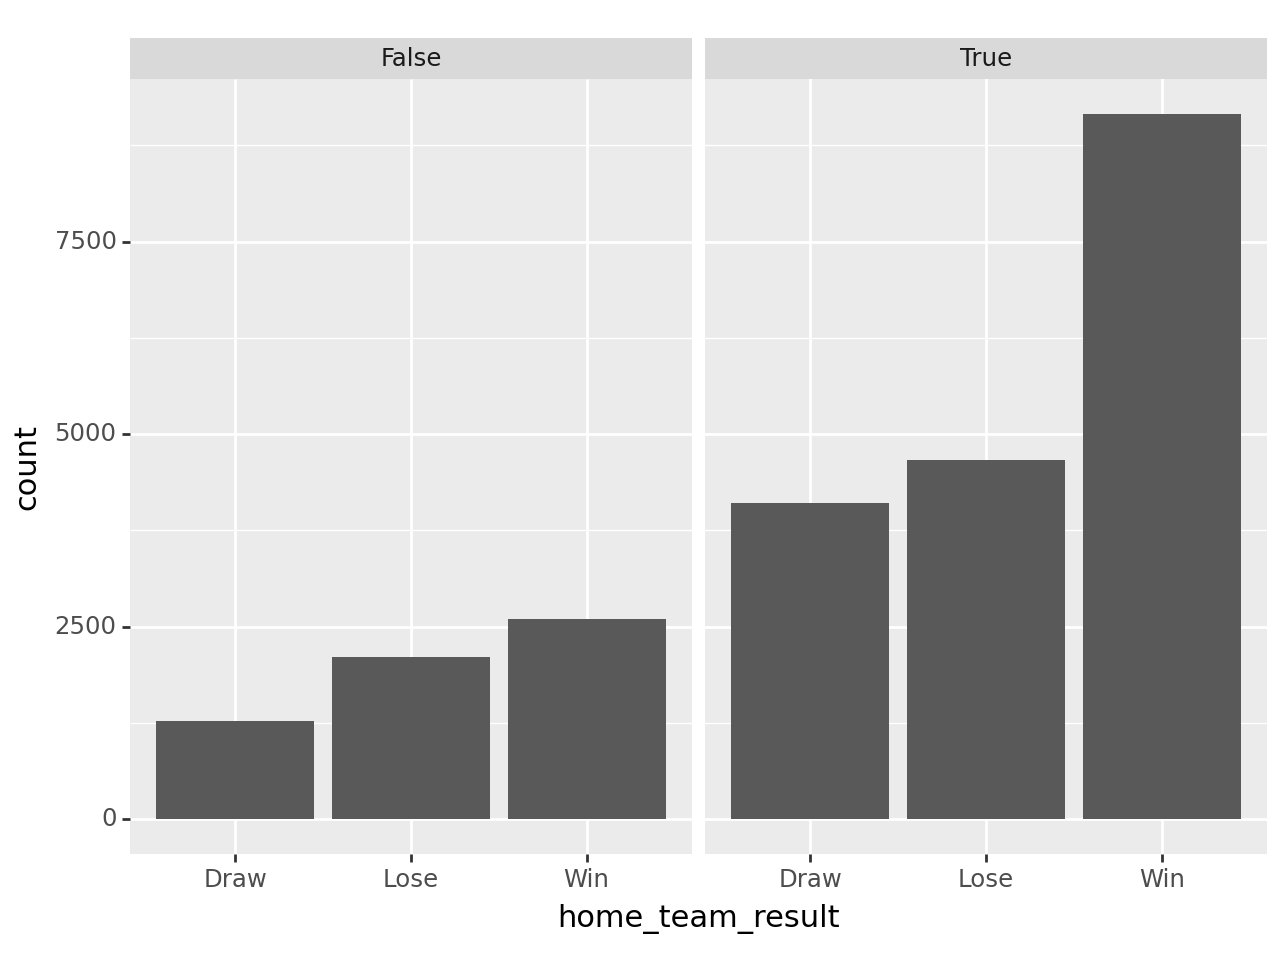

<Figure Size: (640 x 480)>

In [22]:
(ggplot(result, aes("home_team_result"))
+ geom_bar()
+ facet_wrap("team_playing_home")
)

In [23]:
count_results = result_by_location.copy().to_frame().reset_index()

contingeny_table = count_results.pivot(
    index="home_team_result",
    columns="team_playing_home",
    values="count",
)

In [24]:
_, p_valor, *_ = chi2_contingency(contingeny_table, correction=True)

nivel_signficancia = 0.05

if p_valor < nivel_signficancia:
    print(f"p valor de {p_valor:.3f}, amostras são diferentes")
else:
    print(
        f"p valor de {p_valor}, amostras não podem ser consideradas diferentes"
    )


p valor de 0.000, amostras são diferentes


# Do teams with more attacking players score more goals? And teams with stronger goalkeepers receive fewer goals?

In [25]:
data_from_earlist_scores = data.iloc[oldest_element_has_score:]

goal_balance = data_from_earlist_scores.copy()

goal_balance["goal_balance"] = goal_balance["home_team_score"] - goal_balance["away_team_score"]

In [26]:
goal_balance_home_team = goal_balance[
    [
        "date",
        "home_team",
        "home_team_score",
        "away_team_score",
        "home_team_goalkeeper_score",
        "home_team_mean_offense_score",
        "goal_balance"
    ]
]

goal_balance_away_team = goal_balance[
    [
        "date",
        "away_team",
        "home_team_score",
        "away_team_score",
        "away_team_goalkeeper_score",
        "away_team_mean_offense_score",
        "goal_balance"
    ]
]

goal_balance_away_team["goal_balance"] = -1 * goal_balance_away_team["goal_balance"]

/tmp/ipykernel_10656/726001651.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [27]:
goal_balance_home_team_renamed = goal_balance_home_team.rename(
    columns={
        "home_team": "team",
        "home_team_score": "goals_scored",
        "away_team_score": "goals_conceded",
        "home_team_goalkeeper_score": "goalkeeper_score",
        "home_team_mean_offense_score": "attack_score",
    }
)

goal_balance_away_team_renamed = goal_balance_away_team.rename(
    columns={
        "away_team": "team",
        "home_team_score": "goals_conceded",
        "away_team_score": "goals_scored",
        "away_team_goalkeeper_score": "goalkeeper_score",
        "away_team_mean_offense_score": "attack_score",
    }
)


In [28]:
total_balance = pd.concat(
    [goal_balance_home_team_renamed, goal_balance_away_team_renamed]
)

total_balance_all_indicators = total_balance.dropna()


In [29]:
average_indicators = total_balance_all_indicators.groupby("team")[
    ["goals_scored", "goals_conceded", "goalkeeper_score", "attack_score", "goal_balance"]
].mean()


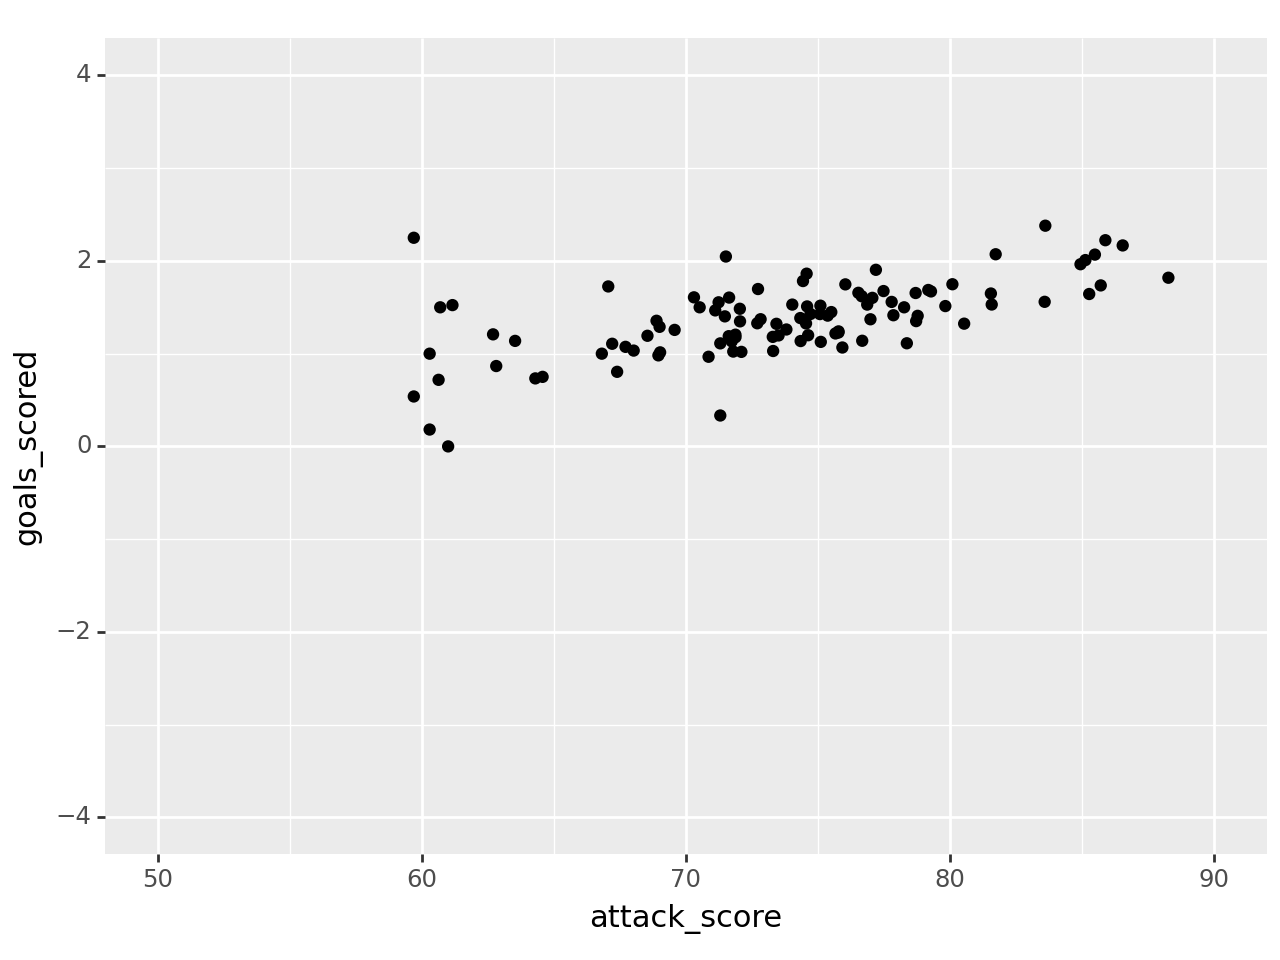

<Figure Size: (640 x 480)>

In [30]:
p = ggplot(aes(x='attack_score', y='goals_scored'), average_indicators)
p + geom_point() + coord_cartesian(xlim=(50,90), ylim=(-4, 4))

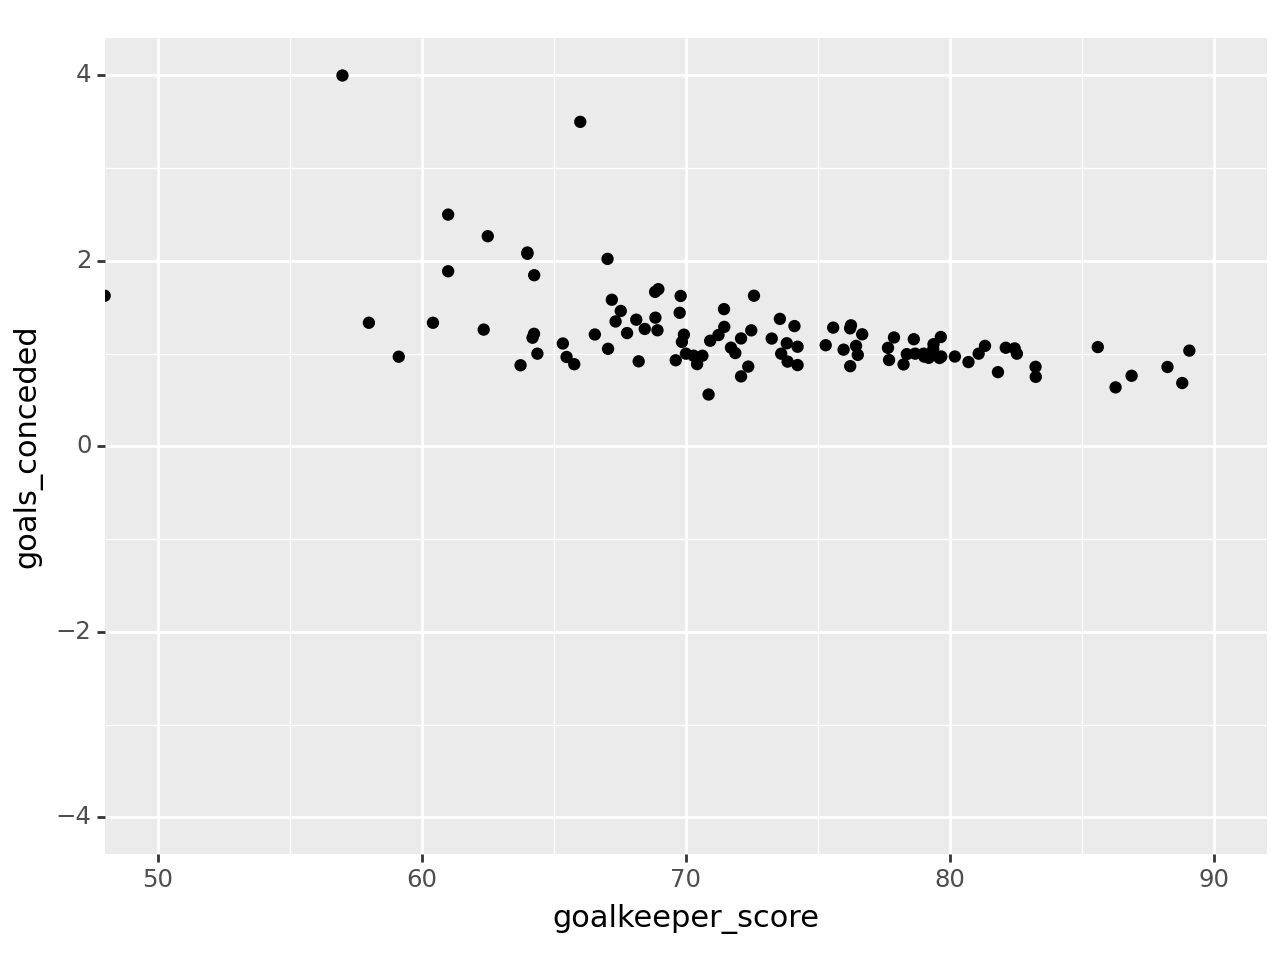

<Figure Size: (640 x 480)>

In [31]:
p = ggplot(aes(x='goalkeeper_score', y='goals_conceded'), average_indicators)
p + geom_point() + coord_cartesian(xlim=(50,90), ylim=(-4, 4))

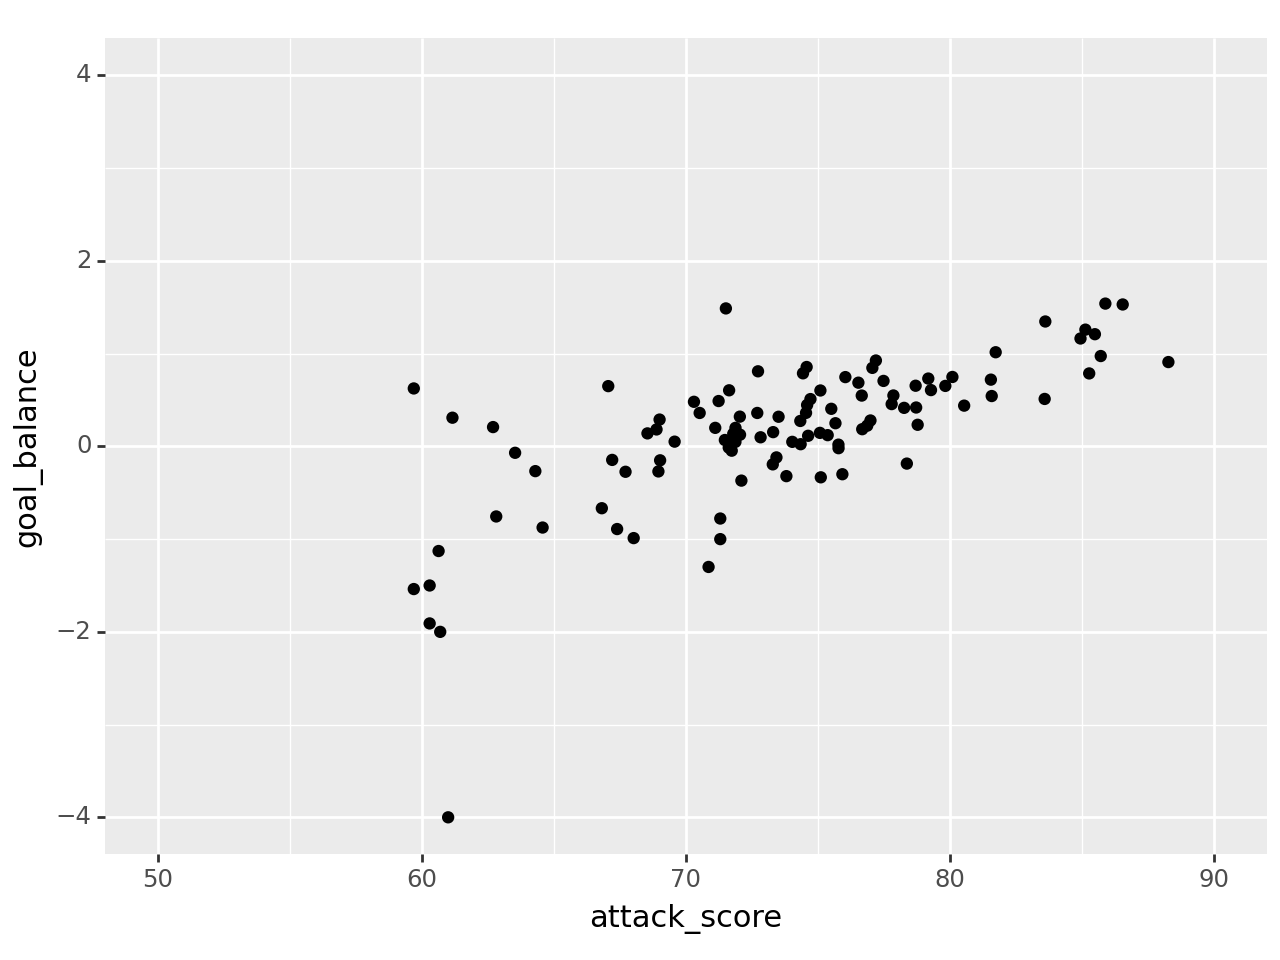

<Figure Size: (640 x 480)>

In [32]:
p = ggplot(aes(x='attack_score', y='goal_balance'), average_indicators)
p + geom_point() + coord_cartesian(xlim=(50,90), ylim=(-4, 4))

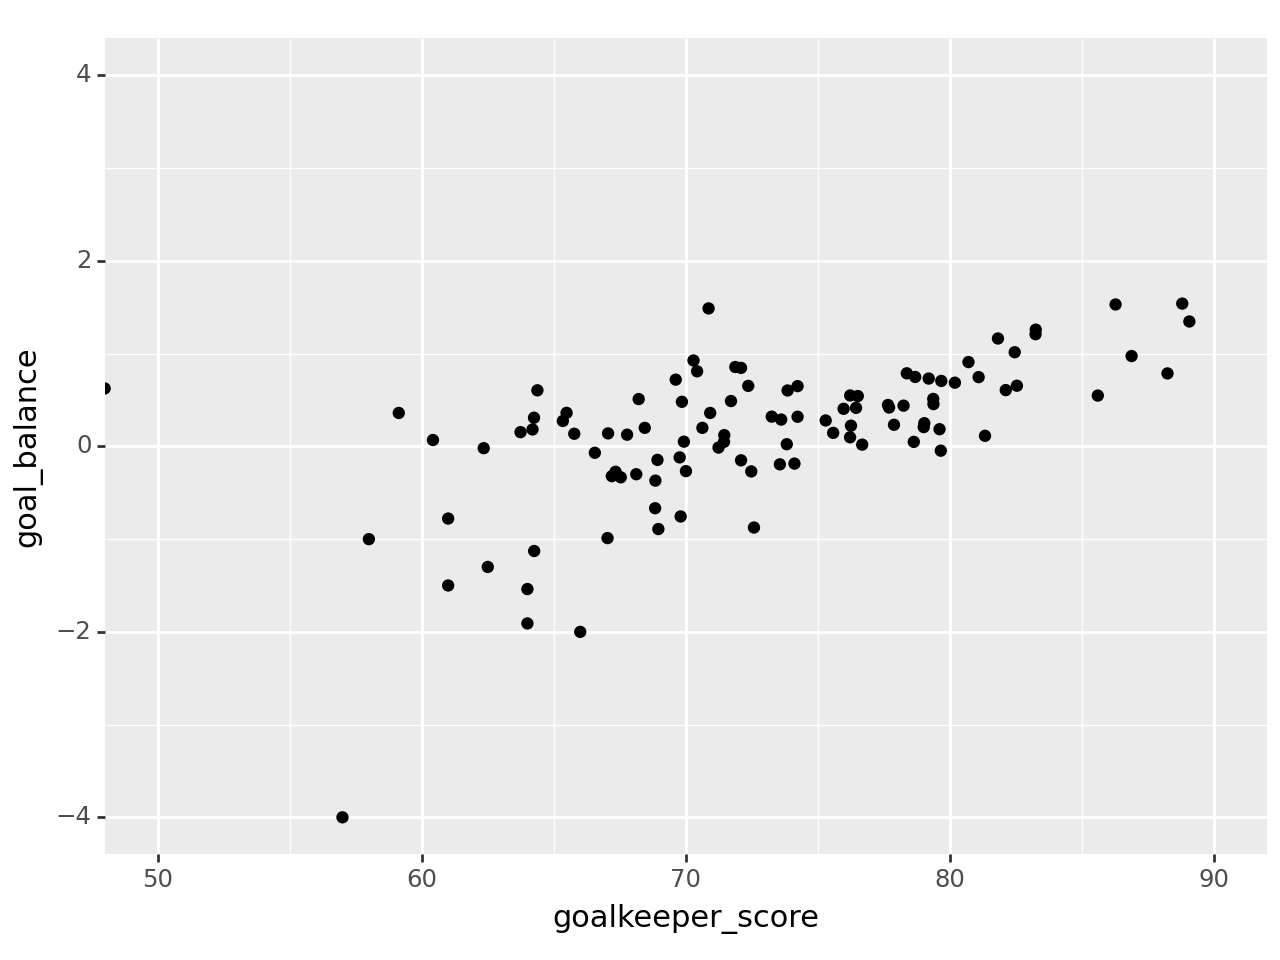

<Figure Size: (640 x 480)>

In [33]:
p = ggplot(aes(x='goalkeeper_score', y='goal_balance'), average_indicators)
p + geom_point() + coord_cartesian(xlim=(50,90), ylim=(-4, 4))

In [34]:
teams_per_goals_scored = average_indicators.sort_values(
    by="goals_scored", ascending=False
)
teams_per_goals_conceded = average_indicators.sort_values(
    by="goals_conceded", ascending=False
)

In [35]:
teams_per_goals_scored

,goals_scored,goals_conceded,goalkeeper_score,attack_score,goal_balance
team,,,,,
Germany,2.380165,1.033058,89.053719,83.602066,1.347107
Barbados,2.250000,1.625000,48.000000,59.700000,0.625000
Spain,2.223629,0.683544,88.784810,85.874684,1.540084
Brazil,2.167347,0.636735,86.261224,86.531020,1.530612
Belgium,2.072165,1.056701,82.443299,81.723196,1.015464
...,...,...,...,...,...
Moldova,0.717949,1.846154,64.256410,60.638462,-1.128205
Cyprus,0.538462,2.076923,64.000000,59.700000,-1.538462
Guinea-Bissau,0.333333,1.333333,58.000000,71.300000,-1.000000


In [36]:
teams_per_goals_conceded

,goals_scored,goals_conceded,goalkeeper_score,attack_score,goal_balance
team,,,,,
Central African Republic,0.000000,4.000000,57.000000,61.000000,-4.000000
Haiti,1.500000,3.500000,66.000000,60.700000,-2.000000
Bermuda,1.000000,2.500000,61.000000,60.300000,-1.500000
Armenia,0.966667,2.266667,62.500000,70.856667,-1.300000
Malta,0.181818,2.090909,64.000000,60.300000,-1.909091
...,...,...,...,...,...
Morocco,1.602041,0.755102,72.086735,77.056122,0.846939
England,2.009259,0.750000,83.240741,85.118981,1.259259
Spain,2.223629,0.683544,88.784810,85.874684,1.540084


### Analyzing Barbados

In [37]:
matches_barbados = (data["home_team"] == "Barbados") | (data["away_team"] == "Barbados")

data_barbados = data.loc[matches_barbados]

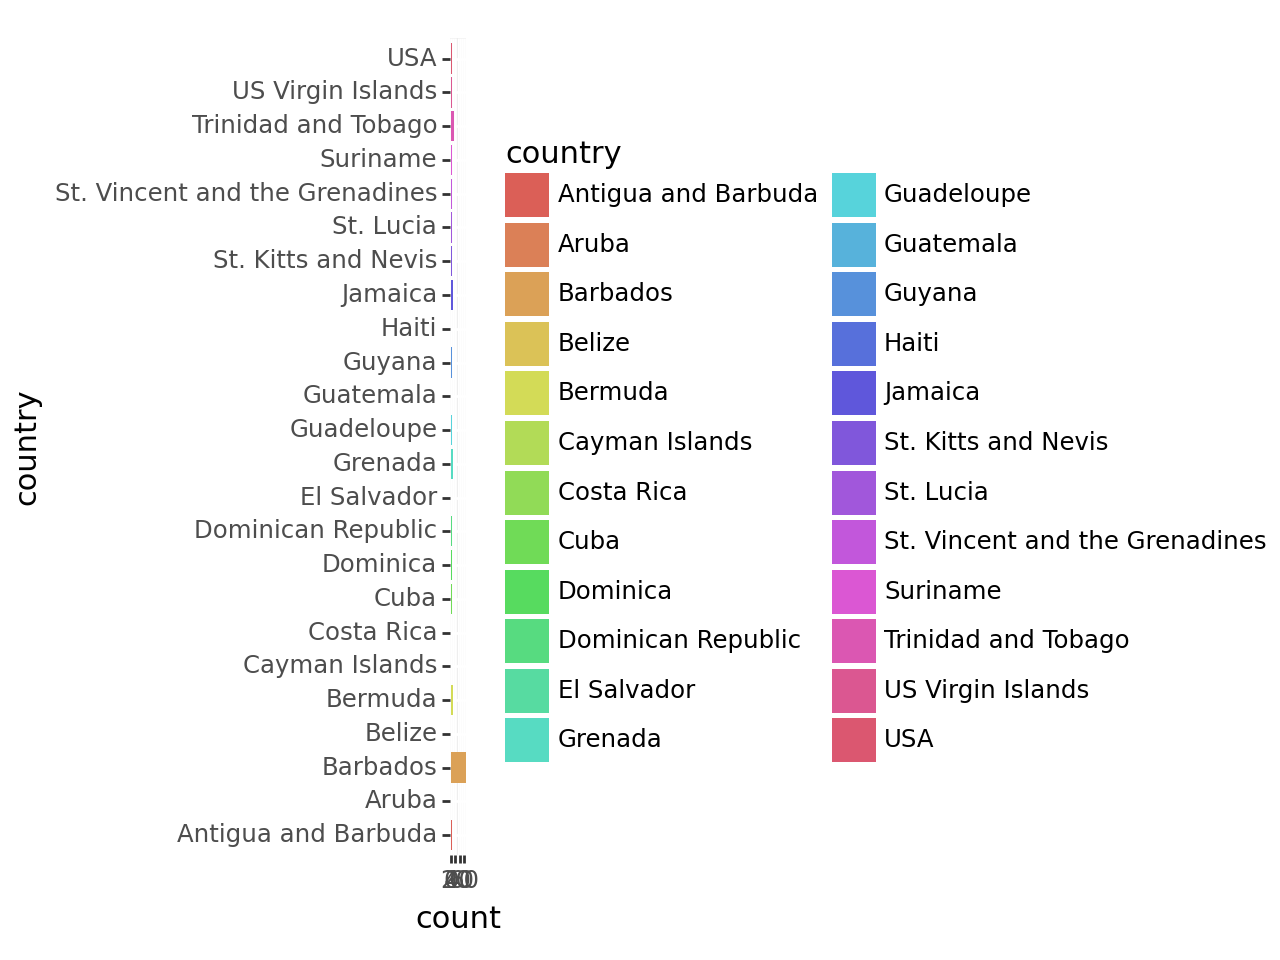

<Figure Size: (640 x 480)>

In [38]:
p = ggplot(data_barbados, aes('country', fill='country'))
p  + geom_bar() + coord_flip()

## Is the attack of teams that scored the most goals different from those that scored the least? And the goalkeeper's score for those who scored the most goals?

In [39]:
n_most_relevant = 20


more_scored_goals = teams_per_goals_scored.iloc[:n_most_relevant]
less_scored_goals = teams_per_goals_scored.iloc[-n_most_relevant:]

more_conceded_goals = teams_per_goals_conceded.iloc[:n_most_relevant]
less_conceded_goals = teams_per_goals_conceded.iloc[-n_most_relevant:]

attack_score_more_scored_goals = more_scored_goals["attack_score"].values
attack_score_less_scored_goals = less_scored_goals["attack_score"].values

goalkeeper_score_more_conceded_goals = more_scored_goals["goalkeeper_score"].values
goalkeeper_score_less_conceded_goals = less_conceded_goals["goalkeeper_score"].values

In [40]:
_, p_valor = ztest(attack_score_more_scored_goals, attack_score_less_scored_goals, value=0)

nivel_significancia = 0.05

if p_valor < nivel_signficancia:
    print(f"p value of {p_valor:.3f}, attacks are different ")
else:
    print(
        f"p value of {p_valor}, attacks can't be considered different"
    )


p value of 0.000, attacks are different 


In [41]:
_, p_valor = ztest(
    goalkeeper_score_more_conceded_goals, goalkeeper_score_less_conceded_goals, value=0
)

if p_valor < nivel_signficancia:
    print(f"p value of {p_valor:.3f}, goalkeepers are different")
else:
    print(
        f"p value of {p_valor}, goalkeepers can't be considered different"
    )

p value of 0.5736169650940238, goalkeepers can't be considered different


# Which team has the longest winning streak?

In [42]:
matches_home = data[["date", "home_team", "tournament", "city", "country", "home_team_result"]]

partidas_away = data[["date", "away_team", "tournament", "city", "country", "home_team_result"]]

In [43]:
matches_home_no_draw = matches_home.copy()
matches_home_no_draw.loc[matches_home_no_draw["home_team_result"] == "Draw", "home_team_result"] = np.nan

matches_home_no_draw = matches_home_no_draw.dropna()


matches_away_no_draw = partidas_away.copy()
matches_away_no_draw.loc[matches_away_no_draw["home_team_result"] == "Draw", "home_team_result"] = np.nan

matches_away_no_draw = matches_away_no_draw.dropna()

In [44]:
matches_home_no_draw["won"] = matches_home_no_draw["home_team_result"] == "Win"

matches_away_no_draw["won"] = matches_away_no_draw["home_team_result"] == "Lose"

In [45]:
matches_home_no_draw = matches_home_no_draw.rename(columns={"home_team": "team"})
matches_home_no_draw = matches_home_no_draw.drop(columns=["home_team_result"])

matches_away_no_draw = matches_away_no_draw.rename(columns={"away_team": "team"})
matches_away_no_draw = matches_away_no_draw.drop(columns=["home_team_result"])

In [46]:
result_matches = pd.concat([matches_home_no_draw, matches_away_no_draw], axis=0)

result_matches_ordered = result_matches.sort_values(by=["team", "date"]).reset_index(drop=True)

In [47]:
teams = result_matches_ordered["team"].unique()

largest_winning_streak = 0
team_largest_winning_streak = None

for team in teams:

    results_team = result_matches_ordered[result_matches_ordered["team"] == team]

    winnings_team = results_team["won"].values

    winning_streak = [list(group) for item, group in groupby(winnings_team) if item == True]

    largest_winning_streak_team = len(max(winning_streak, key=len))

    if largest_winning_streak_team > largest_winning_streak:
        largest_winning_streak = largest_winning_streak_team
        team_largest_winning_streak = team


In [48]:
print(f"team with the longest winning streak was {team_largest_winning_streak}, with {largest_winning_streak} wins")

team with the longest winning streak was Spain, with 33 wins


# Classifier to predict defeat

## Disregarding ties

In [49]:
data_no_draw = data_from_earlist_scores[data_from_earlist_scores["home_team_result"] != "Draw"]


matches_home_team_playing_home = data_no_draw["country"] == data_no_draw["home_team"]
matches_away_team_playing_home = data_no_draw["country"] == data_no_draw["away_team"]

neutral_matches = data_no_draw["neutral_location"]

In [50]:
no_draw_status_where_playing = data_no_draw.copy()

no_draw_status_where_playing.loc[matches_home_team_playing_home, "local_partida"] = "Casa"
no_draw_status_where_playing.loc[matches_away_team_playing_home, "local_partida"] = "Visitante"
no_draw_status_where_playing.loc[neutral_matches, "local_partida"] = "Neutro"

/tmp/ipykernel_10656/2465567376.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Casa' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.


In [51]:
# Não tem partidas no visitante?

no_draw_status_where_playing["local_partida"].value_counts()

local_partida
Casa      8956
Neutro    3150
Name: count, dtype: int64

In [52]:
dev_data = no_draw_status_where_playing.query("date < '01-01-2022'")
test_data = no_draw_status_where_playing.query("date >= '01-01-2022'")

In [53]:
assert dev_data.date.max() <= pd.to_datetime("12-31-2021")
assert test_data.date.min() >= pd.to_datetime("01-01-2022")

In [54]:
dev_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11662 entries, 8262 to 23349
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           11662 non-null  datetime64[ns]
 1   home_team                      11662 non-null  object        
 2   away_team                      11662 non-null  object        
 3   home_team_continent            11662 non-null  object        
 4   away_team_continent            11662 non-null  object        
 5   home_team_fifa_rank            11662 non-null  int64         
 6   away_team_fifa_rank            11662 non-null  int64         
 7   home_team_total_fifa_points    11662 non-null  int64         
 8   away_team_total_fifa_points    11662 non-null  int64         
 9   home_team_score                11662 non-null  int64         
 10  away_team_score                11662 non-null  int64         
 11  tournament       

In [55]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 450 entries, 23350 to 23920
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           450 non-null    datetime64[ns]
 1   home_team                      450 non-null    object        
 2   away_team                      450 non-null    object        
 3   home_team_continent            450 non-null    object        
 4   away_team_continent            450 non-null    object        
 5   home_team_fifa_rank            450 non-null    int64         
 6   away_team_fifa_rank            450 non-null    int64         
 7   home_team_total_fifa_points    450 non-null    int64         
 8   away_team_total_fifa_points    450 non-null    int64         
 9   home_team_score                450 non-null    int64         
 10  away_team_score                450 non-null    int64         
 11  tournament        

In [56]:
name_features = [
    "local_partida",
    "home_team_goalkeeper_score",
    "home_team_mean_defense_score",
    "home_team_mean_offense_score",
    "home_team_mean_midfield_score",
    "away_team_goalkeeper_score",
    "away_team_mean_defense_score",
    "away_team_mean_offense_score",
    "away_team_mean_midfield_score",
]

name_target = "home_team_result"

## Train logistic regression model

### Separate development set into training and testing

In [57]:
features = dev_data[name_features]
features_without_missing = features.fillna(0)

target_encoded = dev_data[name_target].map(lambda x: 0 if x == "Win" else 1)

encoder = TargetEncoder()

features_train, features_val, y_train, y_val = train_test_split(features_without_missing, target_encoded, test_size=0.2)

features_train = encoder.fit_transform(features_train, y_train)

features_val = encoder.transform(features_val)

/home/felipe/.local/share/virtualenvs/fifa_matches_analysis-LZrJL3qn/lib/python3.9/site-packages/category_encoders/utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/felipe/.local/share/virtualenvs/fifa_matches_analysis-LZrJL3qn/lib/python3.9/site-packages/category_encoders/utils.py:28: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/felipe/.local/share/virtualenvs/fifa_matches_analysis-LZrJL3qn/lib/python3.9/site-packages/category_encoders/utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/felipe/.local/share/virtualenvs/fifa_matches_analysis-LZrJL3qn/lib/python3.9/site-packages/category_encoders/utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed i

In [58]:
X_train = features_train.values

X_val = features_val.values

In [59]:
logreg = LogisticRegression()

cross_val_score(logreg, X_train, y_train, cv=3, n_jobs=-1)

array([0.71028939, 0.70836013, 0.7005468 ])

In [60]:
logreg.fit(X_train, y_train)

LogisticRegression()

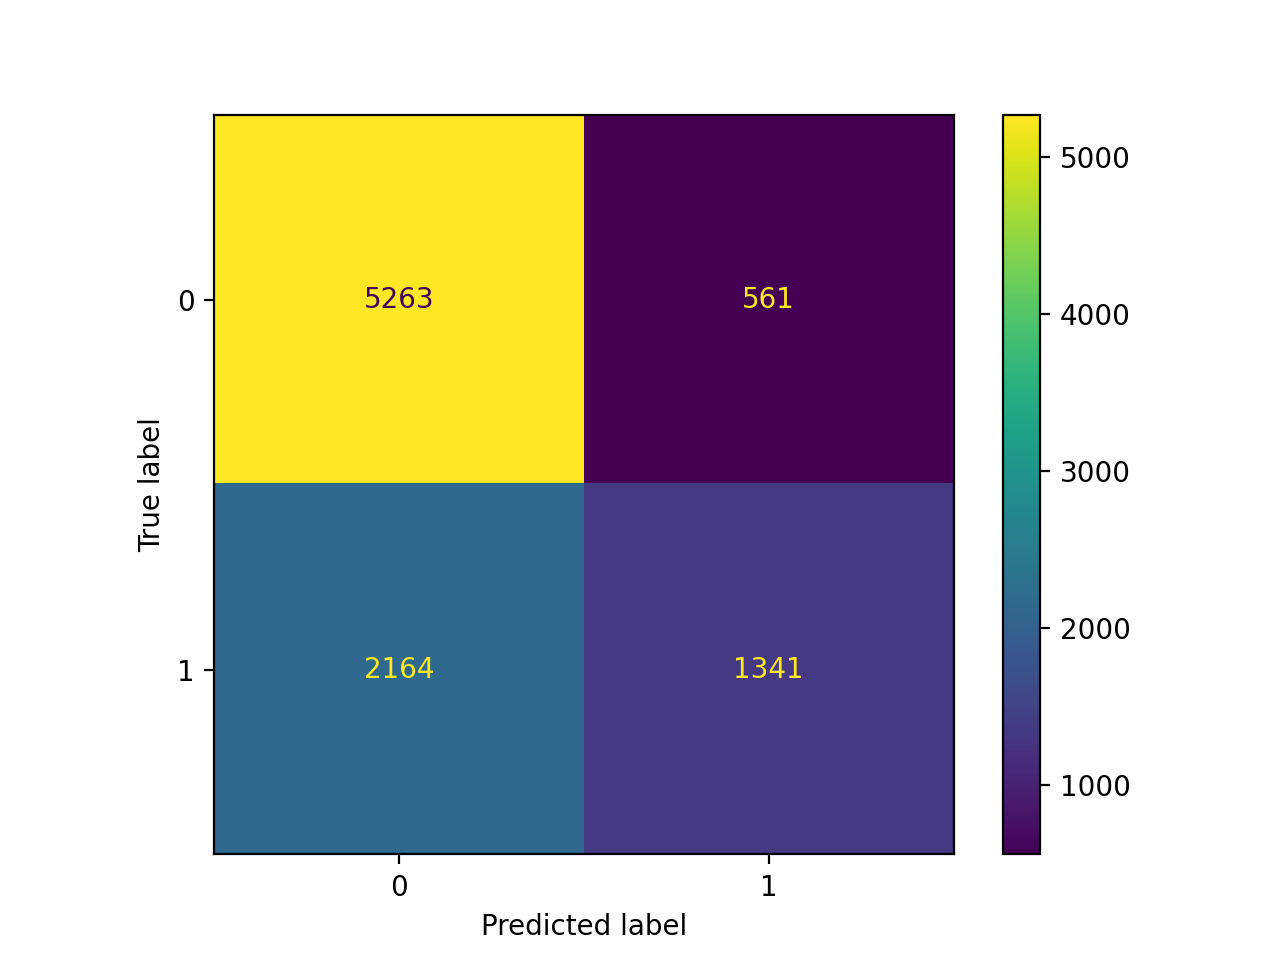

In [61]:
y_pred_train = logreg.predict(X_train)

cm_train = confusion_matrix(y_train, y_pred_train)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_train)

disp.plot()
plt.show()

### Performance for validation set

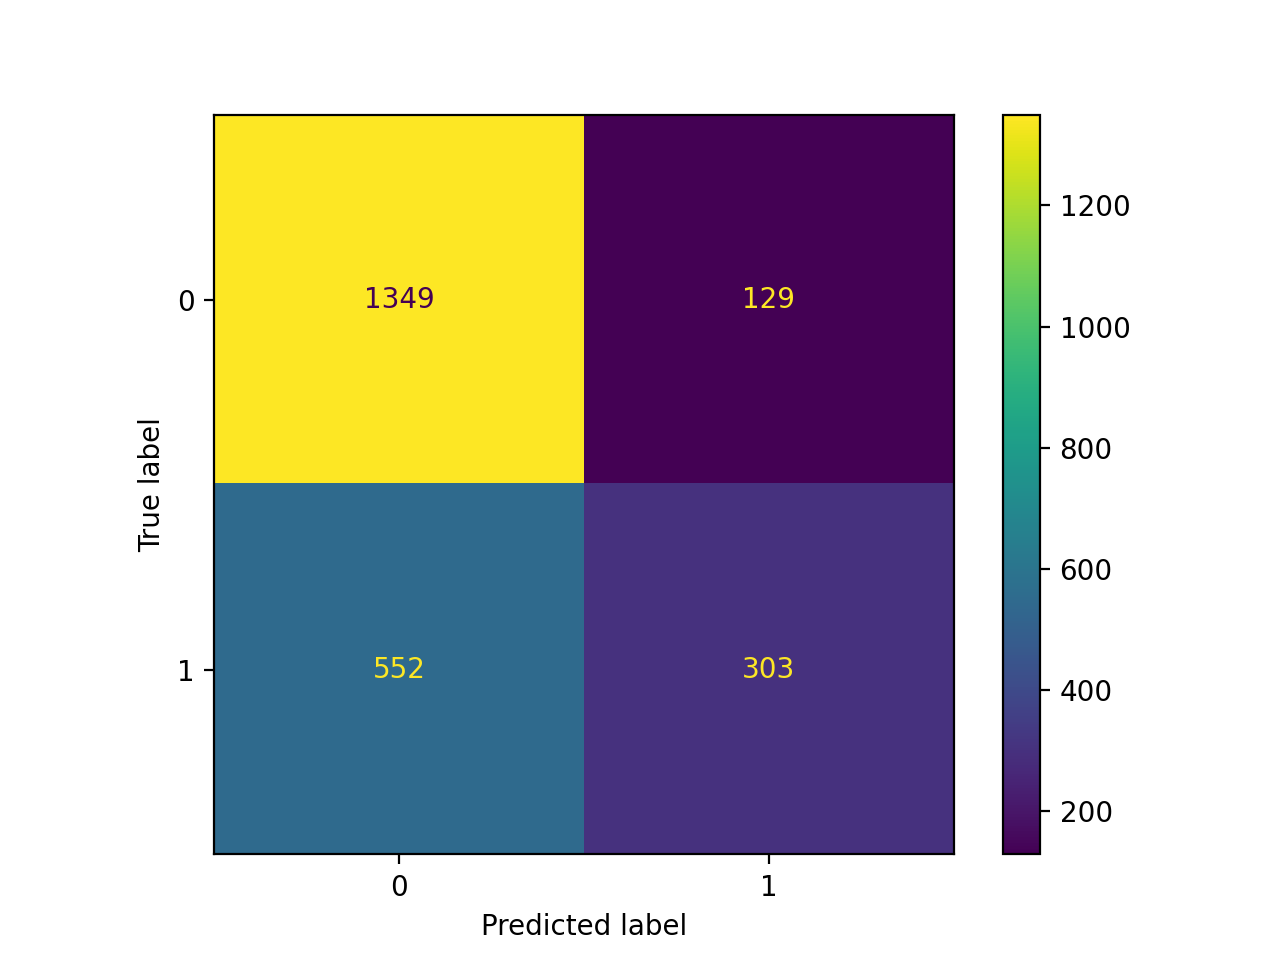

In [62]:
y_pred_val = logreg.predict(X_val)

cm_val = confusion_matrix(y_val, y_pred_val)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_val)

disp.plot()
plt.show()

In [63]:
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.71      0.91      0.80      1478
           1       0.70      0.35      0.47       855

    accuracy                           0.71      2333
   macro avg       0.71      0.63      0.63      2333
weighted avg       0.71      0.71      0.68      2333



### Accuracy and sensitivity curve

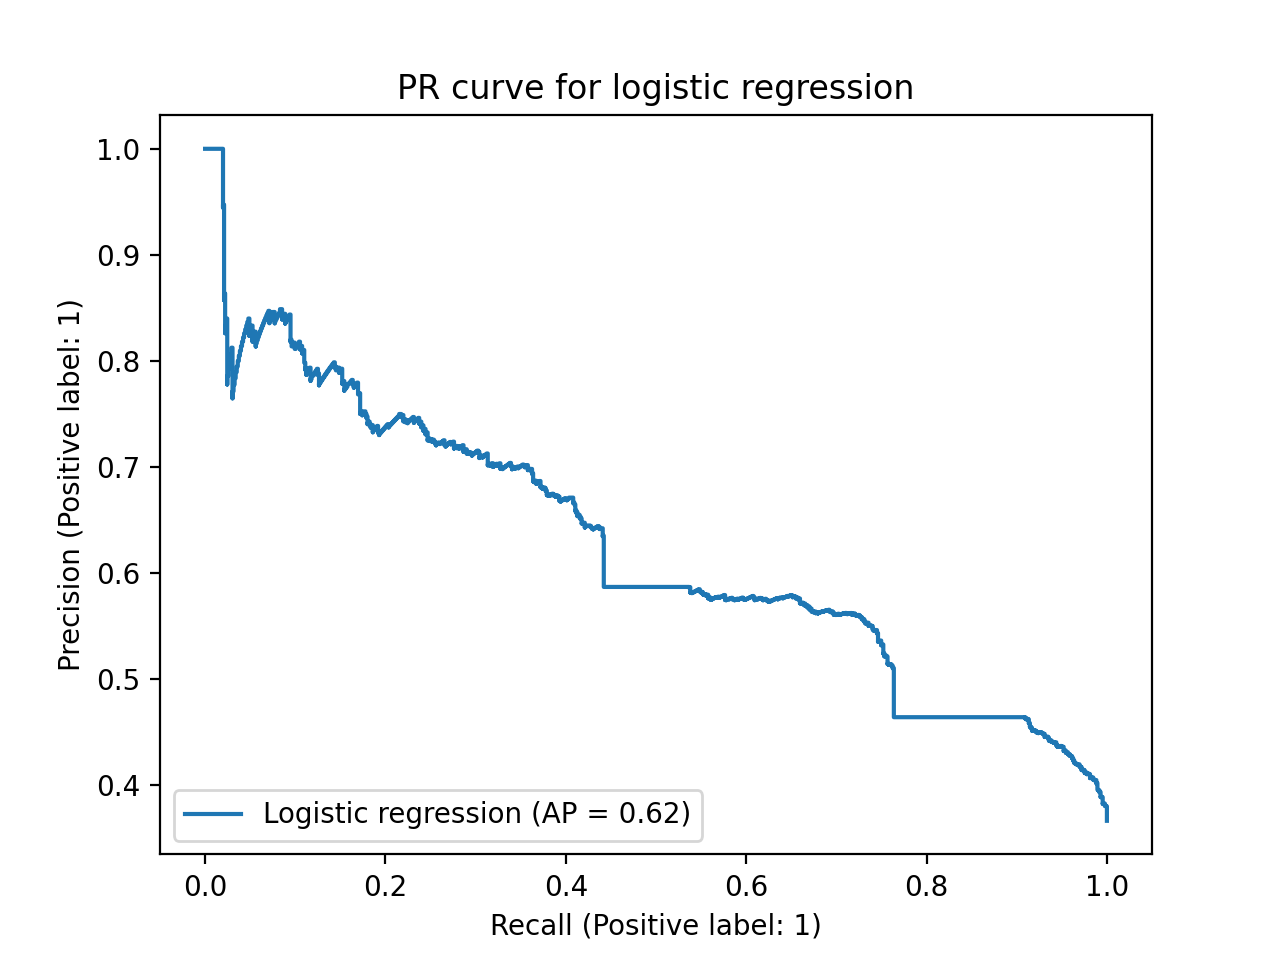

In [64]:
display = PrecisionRecallDisplay.from_estimator(logreg, X_val, y_val, name="Logistic regression")

display.ax_.set_title("PR curve for logistic regression")

plt.show()

In [65]:
def gerar_curva_pr_com_limites(precisions, recalls,thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precission")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Limits")
    plt.legend()

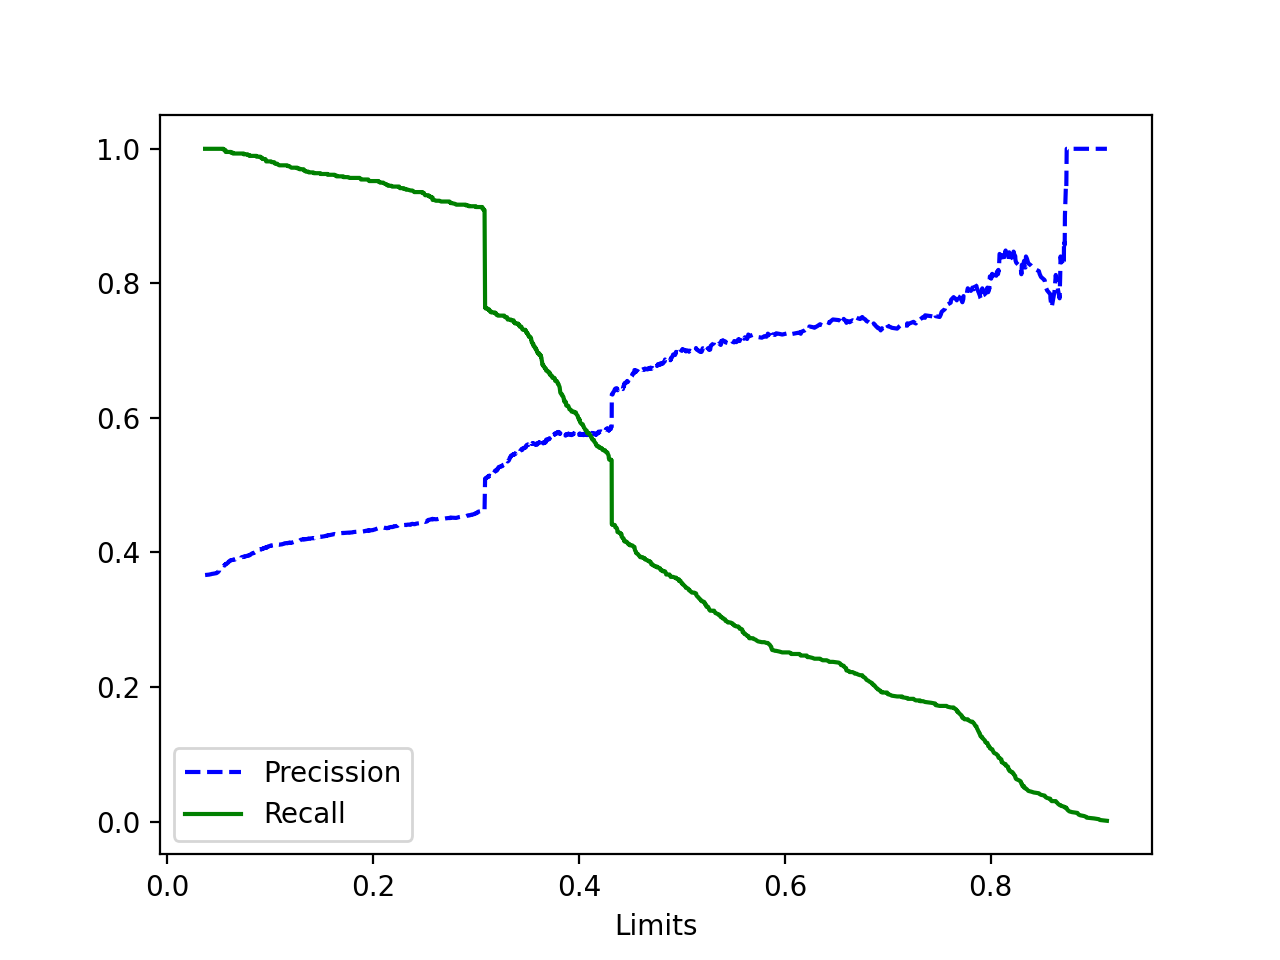

In [66]:
y_val_pred_proba = logreg.predict_proba(X_val)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_pred_proba)

gerar_curva_pr_com_limites(precisions, recalls,thresholds)
plt.show()

## Train Random Forest model

In [67]:
random_forest = RandomForestClassifier()

random_forest.fit(X_train, y_train)

RandomForestClassifier()

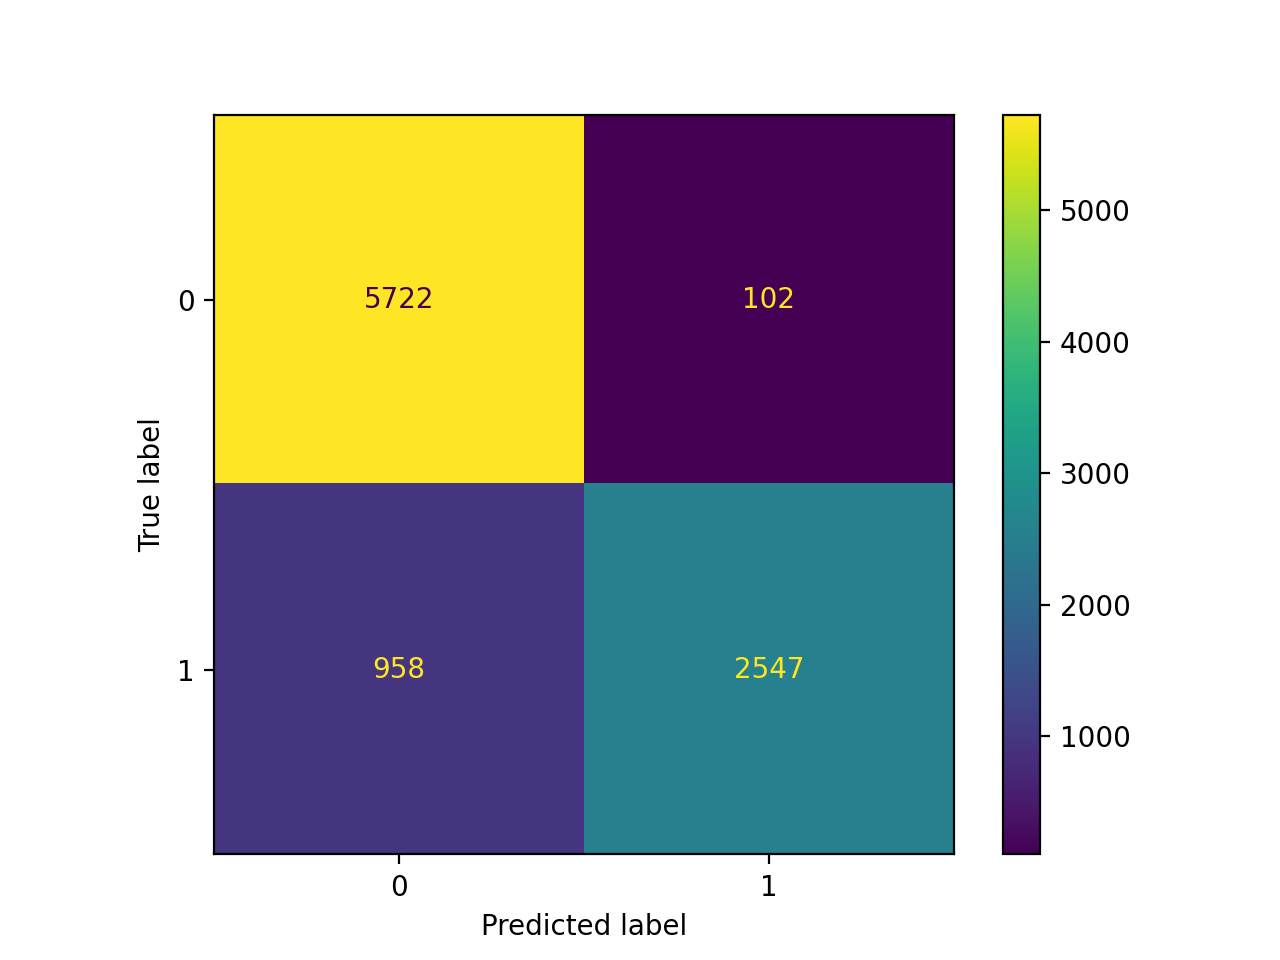

In [68]:
y_pred_train = random_forest.predict(X_train)

cm_train = confusion_matrix(y_train, y_pred_train)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_train)

disp.plot()
plt.show()

### Apply to validation set

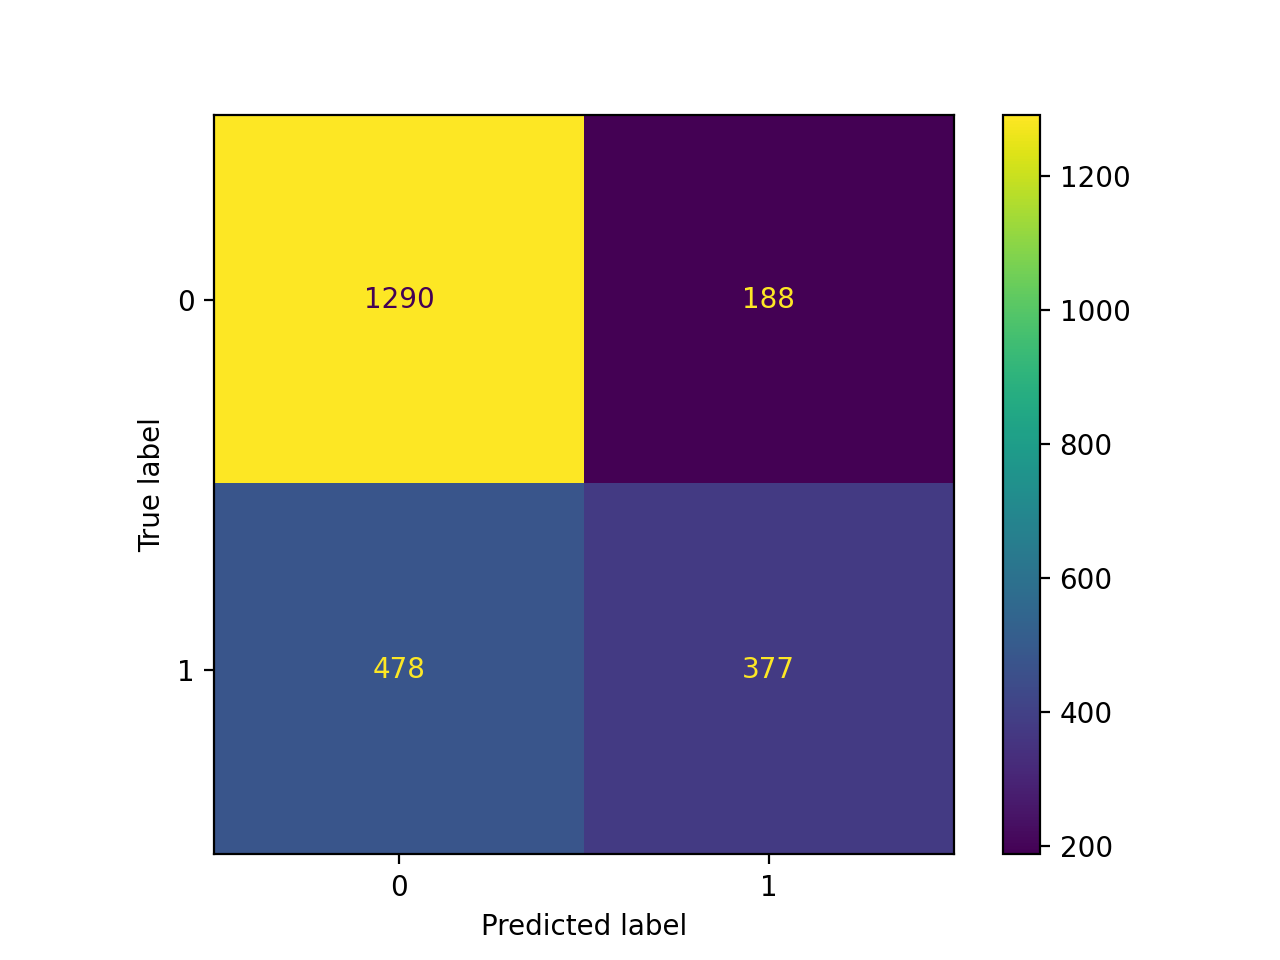

In [69]:
y_pred_val = random_forest.predict(X_val)

cm_val = confusion_matrix(y_val, y_pred_val)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_val)

disp.plot()
plt.show()

In [70]:
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.73      0.87      0.79      1478
           1       0.67      0.44      0.53       855

    accuracy                           0.71      2333
   macro avg       0.70      0.66      0.66      2333
weighted avg       0.71      0.71      0.70      2333



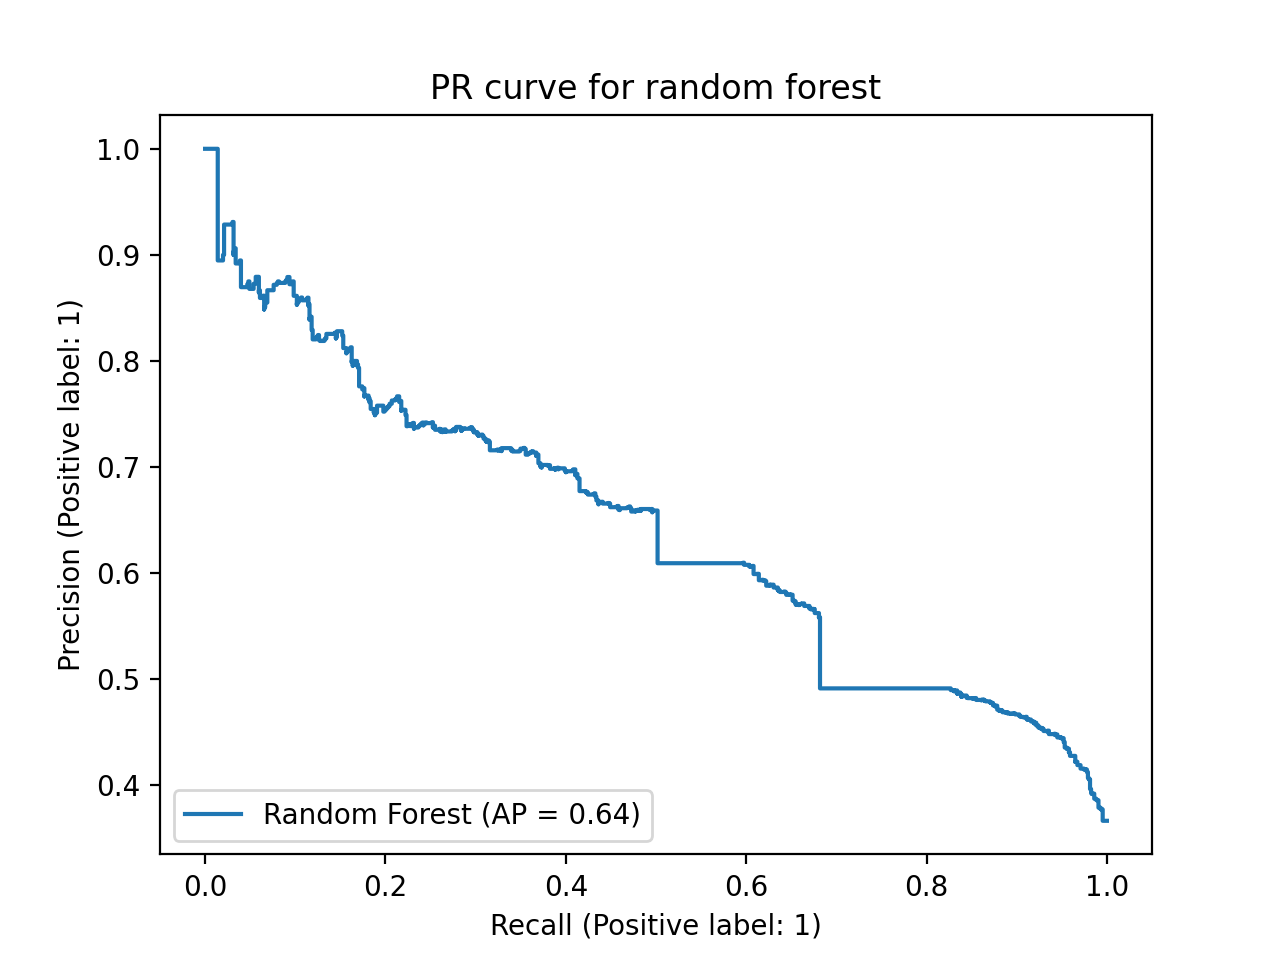

In [71]:
display = PrecisionRecallDisplay.from_estimator(random_forest, X_val, y_val, name="Random Forest")

display.ax_.set_title("PR curve for random forest")

plt.show()

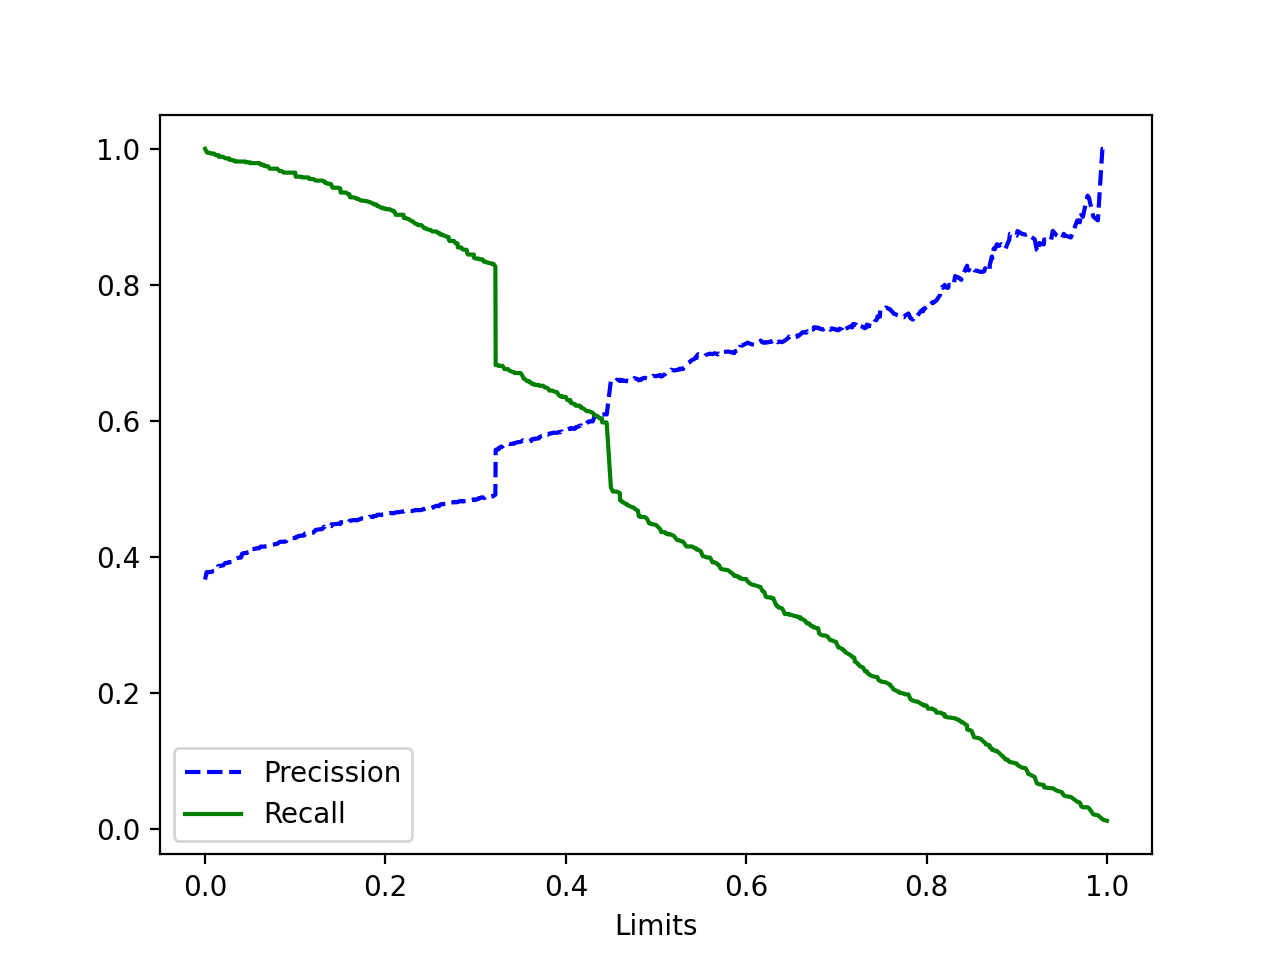

In [72]:
y_val_pred_proba = random_forest.predict_proba(X_val)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_pred_proba)

gerar_curva_pr_com_limites(precisions, recalls,thresholds)
plt.show()

## Apply to test set

In [73]:
features_test = test_data[name_features]
features_test_without_missing = features_test.fillna(0)

target_encoded_test = test_data[name_target].map(lambda x: 0 if x == "Win" else 1)

In [74]:
features_test_encoded = encoder.transform(features_test_without_missing)

/home/felipe/.local/share/virtualenvs/fifa_matches_analysis-LZrJL3qn/lib/python3.9/site-packages/category_encoders/utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


In [75]:
X_test = features_test_encoded.values

y_test = target_encoded_test.values

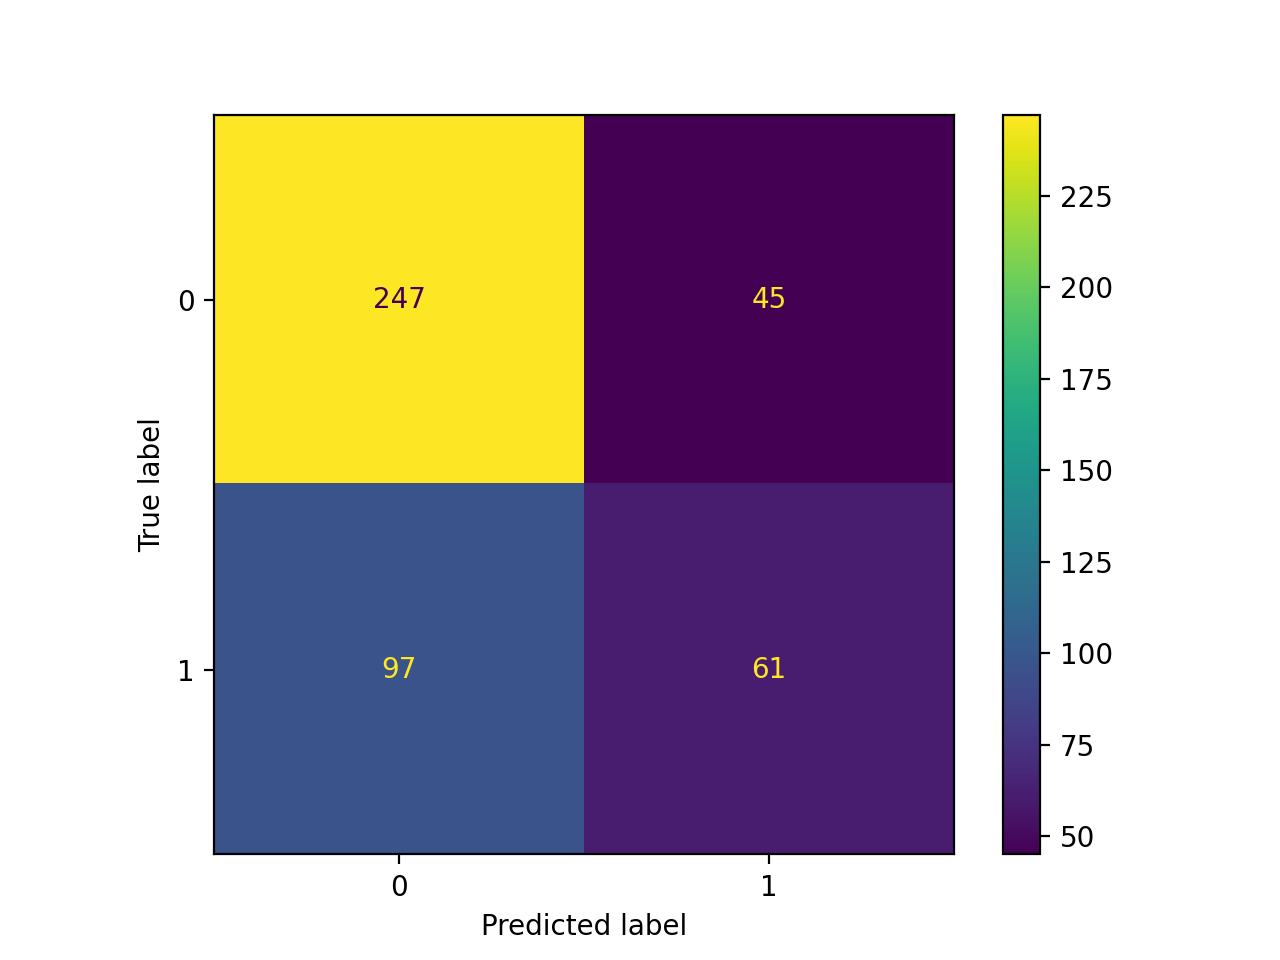

In [76]:
y_pred_test = random_forest.predict(X_test)

cm_dev = confusion_matrix(y_test, y_pred_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_dev)

disp.plot()

plt.show()

In [77]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.72      0.85      0.78       292
           1       0.58      0.39      0.46       158

    accuracy                           0.68       450
   macro avg       0.65      0.62      0.62       450
weighted avg       0.67      0.68      0.67       450

